# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

In [35]:
# Caminhos para os arquivos
base_dir = "G:/EBAC/Base de Dados/UCI HAR Dataset/UCI HAR Dataset/"

# Carregar as bases
X_train = pd.read_csv(f"{base_dir}/train/X_train.txt", delim_whitespace=True, header=None)
X_test = pd.read_csv(f"{base_dir}/test/X_test.txt", delim_whitespace=True, header=None)
y_train = pd.read_csv(f"{base_dir}/train/y_train.txt", delim_whitespace=True, header=None, names=['activity'])
y_test = pd.read_csv(f"{base_dir}/test/y_test.txt", delim_whitespace=True, header=None, names=['activity'])

# Converter y_train e y_test para Series
y_train_series = y_train['activity']
y_test_series = y_test['activity']

print("Bases de dados carregadas com sucesso!")

Bases de dados carregadas com sucesso!


### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [37]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train,
    y_train_series,
    test_size=0.25,
    random_state=42,
    stratify=y_train_series
)

print(f"Tamanho da nova base de treino: {X_train_sub.shape[0]} amostras")
print(f"Tamanho da base de validação: {X_val.shape[0]} amostras")

Tamanho da nova base de treino: 5514 amostras
Tamanho da base de validação: 1838 amostras


### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [41]:
# Ajustar uma árvore com profundidade máxima de 4
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train_sub, y_train_sub)

print("Árvore de decisão com todas as variáveis ajustada com sucesso!")

# Obter a importância das variáveis
importances = clf.feature_importances_
feature_names = X_train.columns

# Criar um Df para visualizar as importâncias
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Importância das variáveis:")
print(feature_importances.head(10))

# Selecionar as 3 melhores variáveis
indices = np.argsort(importances)[::-1][:3]
top_3_vars = X_train_sub.columns[indices]

print(f"As 3 variáveis mais importantes são: {top_3_vars.tolist()}")

Árvore de decisão com todas as variáveis ajustada com sucesso!
Importância das variáveis:
     feature  importance
52        52    0.286326
389      389    0.257330
559      559    0.162623
214      214    0.136890
74        74    0.118864
159      159    0.019418
50        50    0.012081
132      132    0.006469
376      376    0.000000
373      373    0.000000
As 3 variáveis mais importantes são: [52, 389, 559]


### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

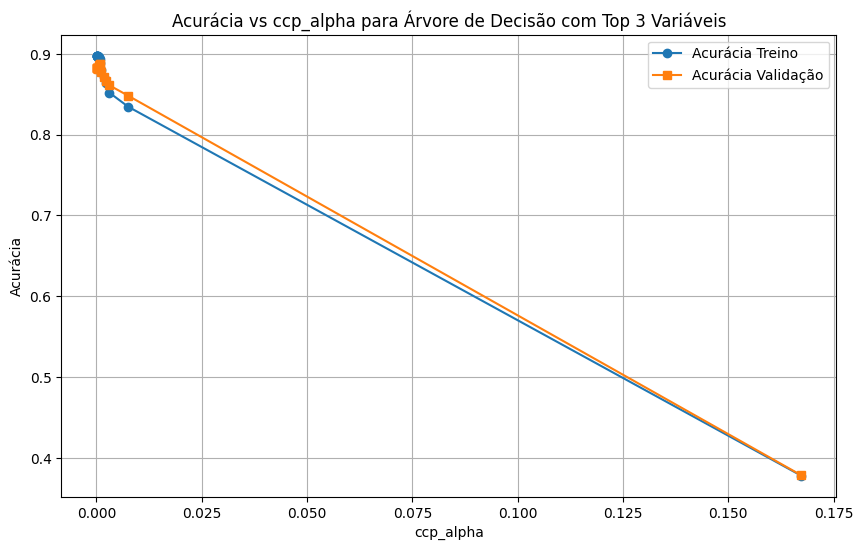

Melhor ccp_alpha encontrado: 0.000930
Melhor acurácia na base de validação: 0.8879
CPU times: total: 328 ms
Wall time: 387 ms


In [45]:
%%time
# Selecionar as 3 melhores
X_train_top3 = X_train_sub[top_3_vars]
X_val_top3 = X_val[top_3_vars]
X_test_top3 = X_test[top_3_vars]

# Ajustar a árvore de decisão inicial com as 3 melhores variáveis
clf_top3 = DecisionTreeClassifier(random_state=42, min_samples_leaf=20)
clf_top3.fit(X_train_top3, y_train_sub)

# Calcular o caminho de complexidade de poda
path = clf_top3.cost_complexity_pruning_path(X_train_top3, y_train_sub)
ccp_alphas = path.ccp_alphas
ccp_alphas = np.unique(ccp_alphas[ccp_alphas > 0])

# Selecionar 1 a cada 5 valores p acelerar
ccp_alphas_subset = ccp_alphas[::5]

# Listas p armazenar árvores e acurácias
trees = []
train_scores = []
val_scores = []

# Ajustar uma árvore p cada ccp
for ccp_alpha in ccp_alphas_subset:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha, min_samples_leaf=20)
    clf.fit(X_train_top3, y_train_sub)
    
    # Calcular a acurácia nas bases de treino e validação
    train_score = clf.score(X_train_top3, y_train_sub)
    val_score = clf.score(X_val_top3, y_val)
    
    trees.append(clf)
    train_scores.append(train_score)
    val_scores.append(val_score)

# Plotar a acurácia em função do ccp
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas_subset, train_scores, marker='o', label='Acurácia Treino')
plt.plot(ccp_alphas_subset, val_scores, marker='s', label='Acurácia Validação')
plt.xlabel('ccp_alpha')
plt.ylabel('Acurácia')
plt.title('Acurácia vs ccp_alpha para Árvore de Decisão com Top 3 Variáveis')
plt.legend()
plt.grid(True)
plt.show()

# Melhor ccp e acurácia na validação
best_index = np.argmax(val_scores)
best_ccp_alpha = ccp_alphas_subset[best_index]
best_val_accuracy = val_scores[best_index]

print(f"Melhor ccp_alpha encontrado: {best_ccp_alpha:.6f}")
print(f"Melhor acurácia na base de validação: {best_val_accuracy:.4f}")


### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

Árvore de decisão final ajustada com o melhor ccp_alpha!
Acurácia na base de testes: 0.6983


<Figure size 1000x800 with 0 Axes>

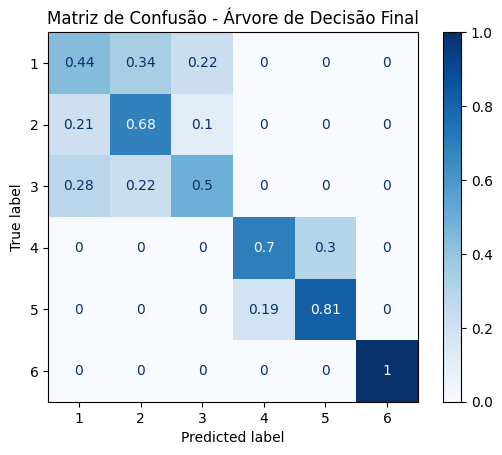

In [47]:
final_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_ccp_alpha, min_samples_leaf=20)
final_clf.fit(X_train_top3, y_train_sub)

print("Árvore de decisão final ajustada com o melhor ccp_alpha!")

# Calcular a acurácia na base de testes
test_accuracy = final_clf.score(X_test_top3, y_test_series)
print(f"Acurácia na base de testes: {test_accuracy:.4f}")

# Plotar a matriz de confusão utilizando ConfusionMatrixDisplay
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test_series,
    final_clf.predict(X_test_top3),
    cmap=plt.cm.Blues,
    normalize='true'
)
plt.title('Matriz de Confusão - Árvore de Decisão Final')
plt.show()